In [66]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import numpy as np
import pandas as pd
import anndata as ad
import muon as mu

import cellij

In [68]:
import pyro
import torch
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [69]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: agg


In [70]:
# plotting functions
def _lines(ax, positions, ymin, ymax, horizontal=False, **kwargs):
    if horizontal:
        ax.hlines(positions, ymin, ymax, **kwargs)
    else:
        ax.vlines(positions, ymin, ymax, **kwargs)
    return ax


def lined_heatmap(data, figsize=None, hlines=None, vlines=None, **kwargs):
    """Plot heatmap with horizontal or vertical lines."""
    if figsize is None:
        figsize = (20, 2)
    fig, g = plt.subplots(figsize=figsize)
    g = sns.heatmap(data, ax=g, **kwargs)
    if hlines is not None:
        _lines(
            g,
            hlines,
            *sorted(g.get_xlim()),
            horizontal=True,
            lw=1.0,
            linestyles="dashed",
        )
    if vlines is not None:
        _lines(
            g,
            vlines,
            *sorted(g.get_ylim()),
            horizontal=False,
            lw=1.0,
            linestyles="dashed",
        )
    return g

In [71]:
# random seed to use throughout the notebook
seed = 123

# basic parameters
n_samples = 100
n_features = [200, 200, 200]
n_views = len(n_features)
likelihoods = ["normal" for _ in range(n_views)]

# more specific parameters to the structure of the latent factors
n_fully_shared_factors = 2
n_partially_shared_factors = 15
n_private_factors = 3

# optional: number of covariates to generate
n_covariates = 2

In [72]:
dg = cellij.core.synthetic.DataGenerator(
    n_samples,
    n_features,
    likelihoods,
    n_covariates=n_covariates,
)

rng = dg.generate(seed=seed)

# introduce missing values in the data
dg.generate_missingness(
    random_fraction=0.1, 
    n_incomplete_samples=10, 
    n_incomplete_features=50, 
    missing_fraction_incomplete_features=0.5, 
    seed=seed
    )

# center data
dg.normalize(with_std=False)

Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.


In [73]:
feature_offsets = [0] + np.cumsum(n_features).tolist()
vlines = feature_offsets[1:-1]

<Axes: >

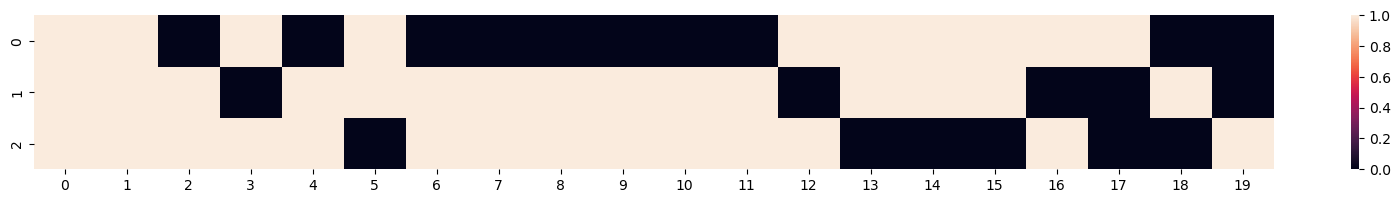

In [74]:
# view factor relationships
lined_heatmap(dg.feature_group_factor_mask)

<Axes: >

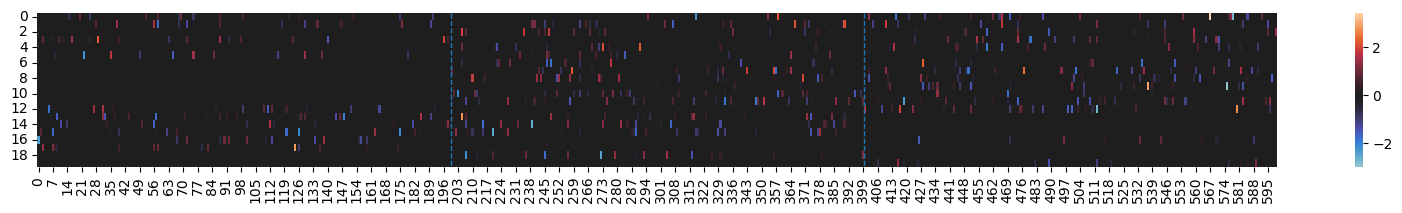

In [75]:
# factor loadings should be fairly sparse
lined_heatmap(dg.w, vlines=vlines, center=0)

<Axes: >

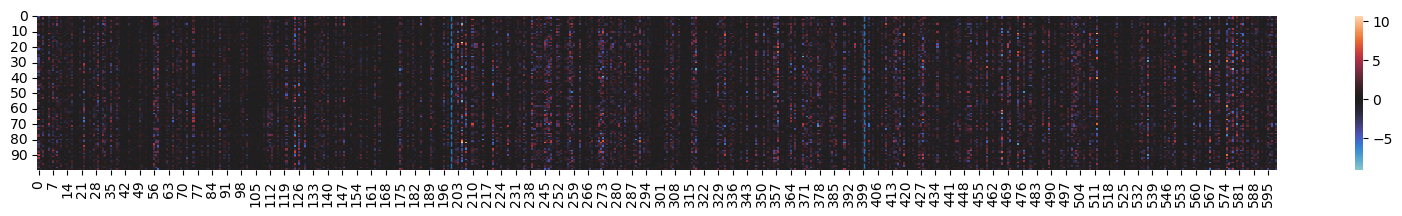

In [76]:
# observed data
lined_heatmap(dg.y, vlines=vlines, center=0)

<Axes: >

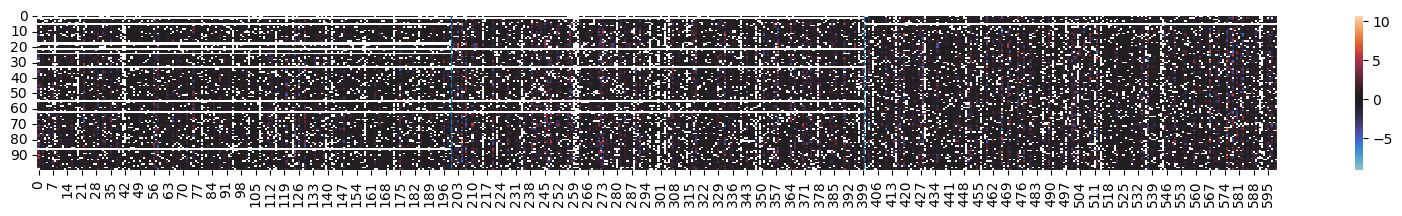

In [77]:
# missing data
lined_heatmap(dg.missing_y, vlines=vlines, center=0)

In [78]:
mdata = mu.MuData({f"view_{m}": ad.AnnData(pd.DataFrame(dg.ys[m], index=[str(i) for i in range(n_samples)], columns=[str(j) for j in range(feature_offsets[m],feature_offsets[m+1])])) for m in range(n_views)})
mdata

MuData object with n_obs × n_vars = 100 × 600
  3 modalities
    view_0:	100 x 200
    view_1:	100 x 200
    view_2:	100 x 200

In [79]:
mdata = cellij._data.Importer().load_CLL()
mdata["mrna"]

AnnData object with n_obs × n_vars = 136 × 5000

In [80]:
model = cellij.core.models.MOFA(n_factors=50, sparsity_prior="Spikeandslab-RelaxedBernoulli")
model.add_data(data=mdata, na_strategy="knn_by_obs")

In [81]:
model.fit(likelihood="Normal",  epochs=10000, verbose_epochs=500)

Epoch      0:    12875630.04
Epoch    500:     8581945.71
Epoch   1000:     7521786.70
Epoch   1500:     7122354.47
Epoch   2000:     6934726.67
Epoch   2500:     6815361.93
Epoch   3000:     6723460.66
Epoch   3500:     6648324.32
Epoch   4000:     6586747.76
Epoch   4500:     6535497.72
Epoch   5000:     6492757.06
Epoch   5500:     6460552.76
Epoch   6000:     6434124.35
Epoch   6500:     6411212.20
Epoch   7000:     6392518.50
Epoch   7500:     6378231.33
Epoch   8000:     6364644.60
Epoch   8500:     6350946.51
Epoch   9000:     6342861.48
Epoch   9500:     6331193.27
Epoch  10000:     6322566.43


In [82]:
w_loc = pyro.get_param_store().get_param("FactorModel._guide.locs.w").detach().cpu().numpy()
w_loc.shape

(50, 9627)

<Axes: >

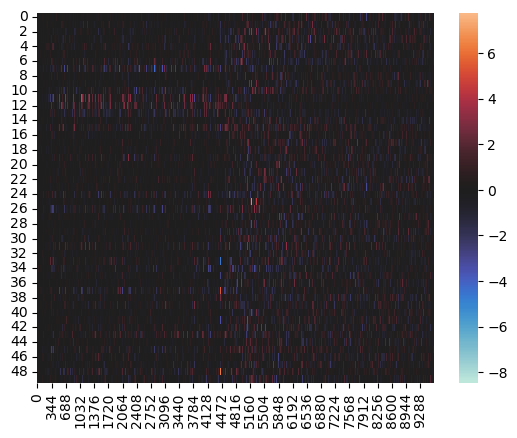

In [83]:
sns.heatmap(w_loc, center=0)